In [1]:
## pycistarget terminal version

import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '/media/ggj/FYT/CH/tmp/'
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [2]:
## ray init
import ray
ray.init('auto')
#ray.init(address='10.105.100.3:6379')
#assert ray.is_initialized() ==True

2023-04-16 03:17:26,426	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.148.185:6379...
2023-04-16 03:17:26,459	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [3]:
#
from scenicplus.scenicplus_class import SCENICPLUS, create_SCENICPLUS_object
from scenicplus.preprocessing.filtering import *

# load data
import pickle
infile = open('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/output/macaca_cluster_cistopicObject.pkl', 'rb')
cistopic_obj = pickle.load(infile)
infile.close()

import pickle
infile = open('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/output/DARs/Imputed_accessibility.pkl', 'rb')
imputed_acc_obj = pickle.load(infile)
infile.close()

infile = open('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/output/pycisTarget/menr.pkl', 'rb') # change here

menr = pickle.load(infile)
infile.close()

In [5]:
## RNA 
from loomxpy.loomxpy import SCopeLoom
from pycisTopic.loom import *
import itertools
import anndata
import scanpy as sc
import numpy as np
rna_anndata = sc.read_loom('/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/macaca_rna_lineage_pseudo_20.loom')
rna_anndata


## Create Scenicplus object.
scplus_obj = create_SCENICPLUS_object(GEX_anndata = rna_anndata, 
                                     cisTopic_obj = cistopic_obj,
                                     imputed_acc_obj = imputed_acc_obj,
                                     menr = menr,
                                     multi_ome_mode = False,
                                     key_to_group_by = 'lineage',
                                     nr_cells_per_metacells = 5)

2023-04-16 03:36:39,561 create scenicplus object INFO     Following annotations were found in both assays under key lineage:
	Epithelial, Endothelial, Muscle, Hepatocyte, Immune, Neural, Stromal, Gut, Renal.
Keeping 1910 cells for RNA and 24308 for ATAC.
2023-04-16 03:39:24,557 create scenicplus object INFO     Automatically set `nr_metacells` to: Endothelial: 50, Epithelial: 116, Gut: 10, Hepatocyte: 124, Immune: 138, Muscle: 76, Neural: 154, Renal: 66, Stromal: 28
2023-04-16 03:39:24,560 create scenicplus object INFO     Generating pseudo multi-ome data


In [6]:
saveDir = outDir + 'scenicplus/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

In [7]:
import scenicplus

In [8]:
from scenicplus.wrappers.run_scenicplus import run_scenicplus

In [9]:
annot=pd.read_csv('./Macaca_geneanno.csv')

In [10]:
import pyranges as pr
annot = pr.PyRanges(annot.dropna(axis=0))

In [11]:
chromsizes = pd.read_csv('/media/ggj/FYT/CH/CH-cross/cluster/compare/fasta/fasc6/macaca.chrom.sizes', sep='\t', header=None)

In [12]:
chromsizes

,0,1
0,1,223606306
1,2,194592313
2,3,186444865
3,4,171057148
4,5,186553353
...,...,...
932,JAANEP010000965.1,1158
933,JAANEP010001440.1,1096
934,JAANEP010001369.1,1050
935,JAANEP010001370.1,1046


In [13]:
chromsizes.columns = ['Chromosome', 'End']
chromsizes['Start'] = [0]*chromsizes.shape[0]
chromsizes = chromsizes.loc[:, ['Chromosome', 'Start', 'End']]

In [14]:
chromsizes = pr.PyRanges(chromsizes)

In [15]:
try:
    sys.stderr = open(os.devnull, "w")  # silence stderr
    run_scenicplus(
        scplus_obj = scplus_obj,
        variable = ['lineage'],
        species = 'mfascicularis',
        #ensembl_assembly=None,ucsc_assembly='macFas5',
        ensembl_assembly=None,ucsc_assembly=None,
        pr_annot=annot,pr_chromsizes=chromsizes,
        tf_file = '/media/ggj/Guo-4T-AI/Scenicplus_database/allTFs_macaca.txt',
        save_path = saveDir,
        biomart_host = 'http://www.ensembl.org/',
        upstream = [1000, 150000],
        downstream = [1000, 150000],
        calculate_TF_eGRN_correlation = False,
        calculate_DEGs_DARs = True,
        export_to_loom_file = False,
        export_to_UCSC_file = False,
        n_cpu = 10,ignore_reinit_error=True,
        _temp_dir = os.path.join(tmpDir, 'ray_spill'))
    sys.stderr = sys.__stderr__  # unsilence stderr
except Exception as e:
    #in case of failure, still save the object
    with open(saveDir + 'scplus_obj', 'wb') as f:
        pickle.dump(scplus_obj, f)
    raise(e)

2023-04-16 03:45:07,393 SCENIC+_wrapper INFO     /media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/output/scenicplus/ folder already exists.
2023-04-16 03:45:07,395 SCENIC+_wrapper INFO     Merging cistromes
2023-04-16 03:45:43,426 SCENIC+_wrapper INFO     Getting search space
2023-04-16 03:45:45,344 R2G          INFO     Extending promoter annotation to 10 bp upstream and 10 downstream
2023-04-16 03:45:45,662 R2G          INFO     Extending search space to:
            						150000 bp downstream of the end of the gene.
            						150000 bp upstream of the start of the gene.
2023-04-16 03:45:47,241 R2G          INFO     Intersecting with regions.
2023-04-16 03:45:48,511 R2G          INFO     Calculating distances from region to gene
2023-04-16 03:48:18,582 R2G          INFO     Imploding multiple entries per region and gene
2023-04-16 03:53:47,344 R2G          INFO     Done!
2023-04-16 03:53:48,017 SCENIC+_wrapper INFO     Inferring region to gene relationships
2023-04-16 03:53:

2023-04-16 04:01:31,338	INFO worker.py:1382 -- Calling ray.init() again after it has already been called.


2023-04-16 04:06:17,873 GSEA         INFO     Subsetting TF2G adjacencies for TF with motif.


2023-04-16 04:06:24,414	INFO worker.py:1544 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


2023-04-16 04:06:25,373 GSEA         INFO     Running GSEA...
2023-04-16 04:10:12,039 GSEA         INFO     Subsetting on adjusted pvalue: 1, minimal NES: 0 and minimal leading edge genes 10
2023-04-16 04:10:12,363 GSEA         INFO     Merging eRegulons
2023-04-16 04:10:12,421 GSEA         INFO     Storing eRegulons in .uns[eRegulons].
2023-04-16 04:10:12,987 SCENIC+_wrapper INFO     Formatting eGRNs
2023-04-16 04:11:13,937 SCENIC+_wrapper INFO     Converting eGRNs to signatures
2023-04-16 04:11:15,124 SCENIC+_wrapper INFO     Calculating eGRNs AUC
2023-04-16 04:11:15,125 SCENIC+_wrapper INFO     Calculating region ranking
2023-04-16 04:13:25,625 SCENIC+_wrapper INFO     Calculating eGRNs region based AUC
2023-04-16 04:13:42,897 SCENIC+_wrapper INFO     Calculating gene ranking
2023-04-16 04:13:43,180 SCENIC+_wrapper INFO     Calculating eGRNs gene based AUC
2023-04-16 04:13:50,587 SCENIC+_wrapper INFO     Binarizing eGRNs AUC
2023-04-16 04:17:01,913 SCENIC+_wrapper INFO     Making eG

... storing 'lineage' as categorical


2023-04-16 04:18:08,458 SCENIC+      INFO     Finished calculating DEGs for variable lineage
2023-04-16 04:18:08,459 SCENIC+      INFO     Calculating DARs for variable lineage
2023-04-16 04:18:54,581 SCENIC+      INFO     There are 114584 variable features


... storing 'lineage' as categorical


2023-04-16 04:19:15,561 SCENIC+      INFO     Finished calculating DARs for variable lineage
2023-04-16 04:19:15,564 SCENIC+_wrapper INFO     Saving object
2023-04-16 04:24:19,460 SCENIC+_wrapper INFO     Finished! Took 39.20111073255539 minutes


# downstream analysis

In [3]:
## pycistarget terminal version

import warnings
warnings.simplefilter(action = 'ignore')
import pycisTopic
pycisTopic.__version__
import numpy as np
import pandas as pd

projDir = '/media/ggj/FYT/CH/CH-cross/Fig3/Scenicplus/macaca/'
outDir = projDir + 'output/'
import os
if not os.path.exists(outDir):
    os.makedirs(outDir)
tmpDir = '/media/ggj/FYT/CH/tmp/'
if not os.path.exists(tmpDir):
    os.makedirs(tmpDir)

In [4]:
ray.shutdown()

In [5]:
## ray init
import ray
ray.init('auto')
#ray.init(address='10.105.100.3:6379')
#assert ray.is_initialized() ==True

2023-04-12 03:31:34,359	INFO worker.py:1364 -- Connecting to existing Ray cluster at address: 210.32.153.239:6379...
2023-04-12 03:31:34,366	INFO worker.py:1544 -- Connected to Ray cluster. View the dashboard at http://127.0.0.1:8265 


Python version:,3.8.13
Ray version:,2.3.0
Dashboard:,http://127.0.0.1:8265


In [6]:
saveDir = outDir + 'scenicplus/'
if not os.path.exists(saveDir):
    os.mkdir(saveDir)

In [7]:
# Downstream analysis
import pickle
infile = open(saveDir + 'scplus_obj.pkl', 'rb')
scplus_obj = pickle.load(infile)
infile.close()

In [16]:
from scenicplus.preprocessing.filtering import apply_std_filtering_to_eRegulons
apply_std_filtering_to_eRegulons(scplus_obj)
scplus_obj.uns['eRegulon_metadata_filtered'].head()

Only keeping positive R2G
Only keep extended if not direct
Getting signatures...
Simplifying eRegulons ...


,Region_signature_name,Gene_signature_name,TF,is_extended,Region,Gene,R2G_importance,R2G_rho,R2G_importance_x_rho,R2G_importance_x_abs_rho,TF2G_importance,TF2G_regulation,TF2G_rho,TF2G_importance_x_abs_rho,TF2G_importance_x_rho,Consensus_name
0,BACH2_+_(15r),BACH2_+_(14g),BACH2,False,10:63552775-63553275,RBCK1,0.024402,0.131730,0.003214,0.003214,0.171427,1,0.061993,0.010627,0.010627,BACH2_+_+
1,BACH2_+_(15r),BACH2_+_(14g),BACH2,False,7:78643657-78644157,MEF2A,0.015392,0.077186,0.001188,0.001188,0.253745,1,0.099052,0.025134,0.025134,BACH2_+_+
2,BACH2_+_(15r),BACH2_+_(14g),BACH2,False,1:95488173-95488673,ZBTB7B,0.025185,0.472839,0.011909,0.011909,0.155569,1,0.073918,0.011499,0.011499,BACH2_+_+
3,BACH2_+_(15r),BACH2_+_(14g),BACH2,False,1:95504591-95505091,ZBTB7B,0.021202,0.506987,0.010749,0.010749,0.155569,1,0.073918,0.011499,0.011499,BACH2_+_+
4,BACH2_+_(15r),BACH2_+_(14g),BACH2,False,2:142156461-142156961,MKRN2,0.010124,0.074795,0.000757,0.000757,0.651644,1,0.072365,0.047156,0.047156,BACH2_+_+


In [9]:
scplus_obj.uns['eRegulon_metadata_filtered'].to_csv(saveDir + 'eRegulon_metadata_filtered.csv')
scplus_obj.uns['eRegulon_metadata'].to_csv(saveDir + 'eRegulon_metadata.csv')

In [17]:
import dill
from scenicplus.eregulon_enrichment import score_eRegulons
region_ranking = dill.load(open(os.path.join(saveDir,  'region_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function
gene_ranking = dill.load(open(os.path.join(saveDir, 'gene_ranking.pkl'), 'rb')) #load ranking calculated using the wrapper function

In [18]:
#auc
score_eRegulons(scplus_obj,
                ranking = region_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type= 'region',
                auc_threshold = 0.1,
                normalize = False,
                n_cpu = 5)
score_eRegulons(scplus_obj,
                gene_ranking,
                eRegulon_signatures_key = 'eRegulon_signatures_filtered',
                key_added = 'eRegulon_AUC_filtered',
                enrichment_type = 'gene',
                auc_threshold = 0.1,
                normalize= False,
                n_cpu = 5)

In [19]:
from scenicplus.cistromes import TF_cistrome_correlation, generate_pseudobulks

generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'lineage',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Gene_based')
generate_pseudobulks(
        scplus_obj = scplus_obj,
        variable = 'lineage',
        auc_key = 'eRegulon_AUC_filtered',
        signature_key = 'Region_based')

TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Gene_based',
            out_key = 'filtered_gene_based')
TF_cistrome_correlation(
            scplus_obj,
            use_pseudobulk = True,
            variable = 'lineage',
            auc_key = 'eRegulon_AUC_filtered',
            signature_key = 'Region_based',
            out_key = 'filtered_region_based')

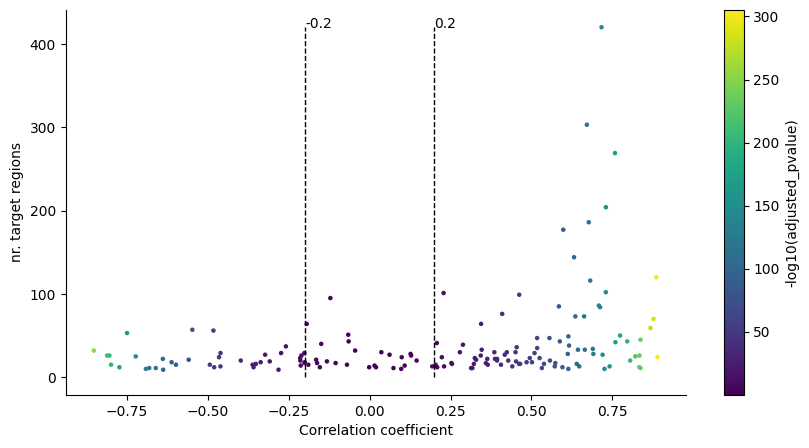

In [20]:
import numpy as np
n_targets = [int(x.split('(')[1].replace('r)', '')) for x in scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Cistrome']]
rho = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'].to_list()
adj_pval = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Adjusted_p-value'].to_list()

thresholds = {
        'rho': [-0.2, 0.2],
        'n_targets': 0
}
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize = (10, 5))
sc = ax.scatter(rho, n_targets, c = -np.log10(adj_pval), s = 5)
ax.set_xlabel('Correlation coefficient')
ax.set_ylabel('nr. target regions')
#ax.hlines(y = thresholds['n_targets'], xmin = min(rho), xmax = max(rho), color = 'black', ls = 'dashed', lw = 1)
ax.vlines(x = thresholds['rho'], ymin = 0, ymax = max(n_targets), color = 'black', ls = 'dashed', lw = 1)
ax.text(x = thresholds['rho'][0], y = max(n_targets), s = str(thresholds['rho'][0]))
ax.text(x = thresholds['rho'][1], y = max(n_targets), s = str(thresholds['rho'][1]))
sns.despine(ax = ax)
fig.colorbar(sc, label = '-log10(adjusted_pvalue)', ax = ax)
plt.show()

In [21]:
selected_cistromes = scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based'].loc[
        np.logical_or(
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] > thresholds['rho'][1],
                scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']['Rho'] < thresholds['rho'][0]
        )]['Cistrome'].to_list()
selected_eRegulons = [x.split('_(')[0] for x in selected_cistromes]
selected_eRegulons_gene_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Gene_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
selected_eRegulons_region_sig = [
        x for x in scplus_obj.uns['eRegulon_signatures_filtered']['Region_based'].keys()
        if x.split('_(')[0] in selected_eRegulons]
#save the results in the scenicplus object
scplus_obj.uns['selected_eRegulon'] = {'Gene_based': selected_eRegulons_gene_sig, 'Region_based': selected_eRegulons_region_sig}
print(f'selected: {len(selected_eRegulons_gene_sig)} eRegulons')

selected: 136 eRegulons


In [42]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_region_based']

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,MAFF,MAFF_+_(10r),0.068476,5.286322e-02,5.351585e-02
1,ZNF148,ZNF148_-_(16r),-0.714701,5.035859e-126,2.173371e-125
2,TCF4,TCF4_-_(12r),-0.836668,7.798800e-211,9.135738e-210
3,FOSL2,FOSL2_+_(27r),0.446336,2.003096e-40,3.570736e-40
4,THRB,THRB_-_(16r),-0.791333,1.076128e-172,8.824250e-172
...,...,...,...,...,...
77,ERG,ERG_extended_-_(24r),-0.295738,1.302430e-17,1.810157e-17
78,CDX1,CDX1_+_(22r),0.898763,5.467970e-288,1.494579e-286
79,MEF2A,MEF2A_+_(16r),0.520465,9.744788e-57,2.159656e-56
80,PPARA,PPARA_+_(15r),0.242103,3.906804e-12,4.576542e-12


In [43]:
scplus_obj.uns['TF_cistrome_correlation']['filtered_gene_based']

,TF,Cistrome,Rho,P-value,Adjusted_p-value
0,MAFF,MAFF_+_(10g),0.755243,1.473522e-148,4.315316e-148
1,ZNF148,ZNF148_-_(11g),-0.700698,3.915466e-119,8.449164e-119
2,TCF4,TCF4_-_(10g),-0.875241,6.176884e-254,1.266261e-252
3,FOSL2,FOSL2_+_(17g),0.684703,9.698415e-112,1.893500e-111
4,THRB,THRB_-_(11g),-0.829665,3.220612e-204,1.760601e-203
...,...,...,...,...,...
77,ERG,ERG_extended_-_(12g),-0.484843,2.127799e-48,3.115706e-48
78,CDX1,CDX1_+_(13g),0.847594,8.239166e-222,6.756116e-221
79,MEF2A,MEF2A_+_(14g),0.839561,1.165588e-213,7.964851e-213
80,PPARA,PPARA_+_(10g),0.173101,8.409380e-07,8.840631e-07


In [47]:
#dotplot

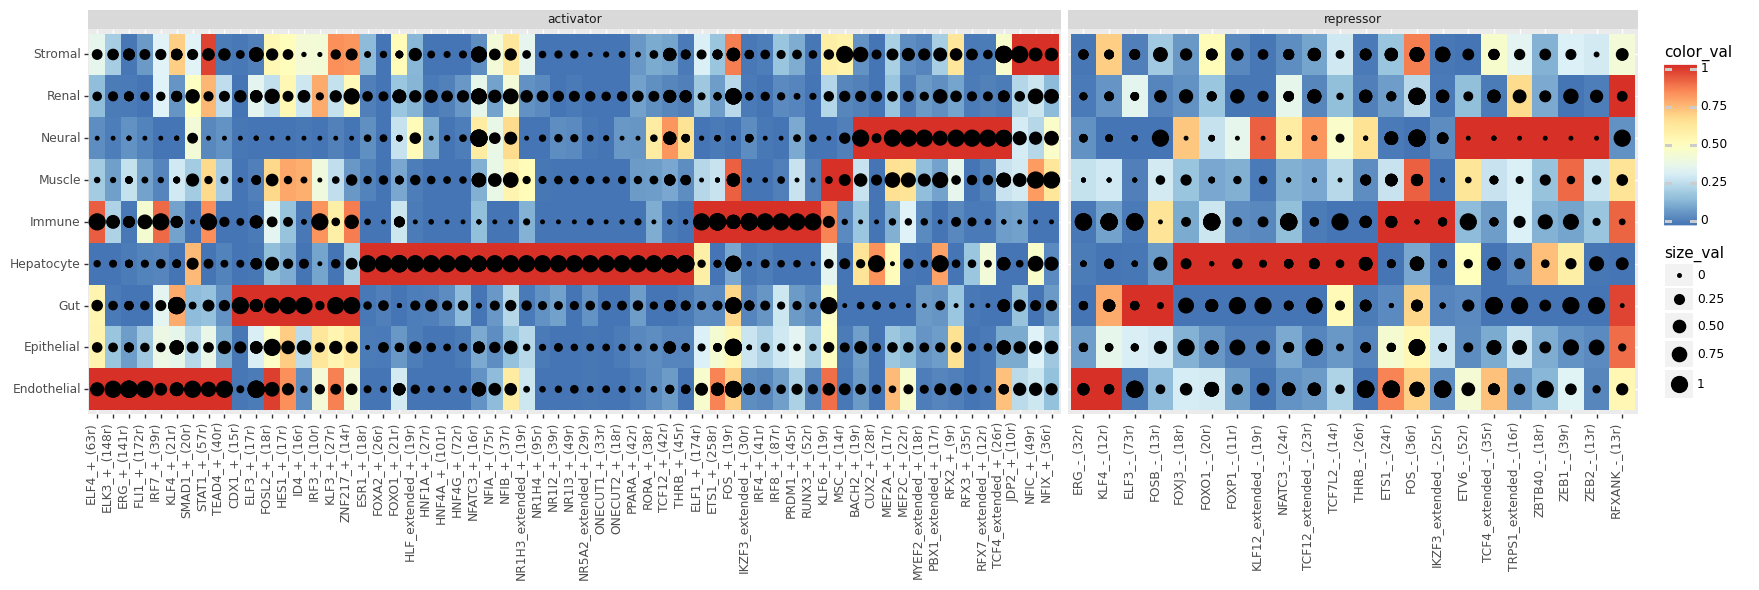

<ggplot: (8723322737857)>

In [19]:
from scenicplus.plotting.dotplot import heatmap_dotplot
import matplotlib.pyplot as plt
heatmap_dotplot(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'], #specify what to plot as dot sizes, target region enrichment in this case
        color_matrix = scplus_obj.to_df('EXP'), #specify  what to plot as colors, TF expression in this case
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'lineage',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'],
        #index_order = ['Astrocytes', 'Oligodendrocytes', 'Microglia', 'Cajal-Retzius cells', 'Purkinje neurons', 'Endothelial cells'], # check here
        figsize = (20, 5),
        orientation = 'horizontal')

In [23]:
import dill
dill.dump(scplus_obj, open(os.path.join(saveDir, 'scplus_obj_total.pkl'), 'wb'), protocol=-1)

In [20]:
use_tf=scplus_obj.uns['selected_eRegulon']['Gene_based']
use_tf=pd.DataFrame(use_tf,index=None)
use_tf.to_csv('./macaca_regulon.csv')

In [22]:
from scenicplus.plotting.dotplot import generate_dotplot_df
plotting_df = generate_dotplot_df(
        scplus_obj = scplus_obj,
        size_matrix = scplus_obj.uns['eRegulon_AUC_filtered']['Region_based'],
        color_matrix = scplus_obj.to_df('EXP'),
        scale_size_matrix = True,
        scale_color_matrix = True,
        group_variable = 'lineage',
        subset_eRegulons = scplus_obj.uns['selected_eRegulon']['Gene_based'])
tmp = plotting_df[['index', 'eRegulon_name', 'color_val']
        ].pivot_table(index = 'index', columns = 'eRegulon_name'
        ).fillna(0)['color_val']
tmp
idx_max = tmp.idxmax(axis = 0)
order = pd.concat([idx_max[idx_max == x] for x in tmp.index.tolist() if len(plotting_df[plotting_df == x]) > 0]).index.tolist()
plotting_df['eRegulon_name'] = pd.Categorical(plotting_df['eRegulon_name'], categories = order)
plotting_df['repressor_activator'] = ['activator' if '+' in n.split('_')[1] and 'extended' not in n or '+' in n.split('_')[2] and 'extended' in n  else 'repressor' for n in plotting_df['eRegulon_name']]
plotting_df.to_csv('./macaca_tfdf_pseudo_20_total.csv')